In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.mvsec as mvsec_dset

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4045]:
#define time range
t_start = 16.013835191726685
duration = 0.3
t_end = t_start + duration
shape = (260, 346)
dataset = "data/MVSEC/"

In [4046]:
events_raw = mvsec_dset.load_events_time(path + dataset + "indoor_flying1_data.hdf5", t_start, t_start+duration)

C:\Users/schiavaz/lava-nc/depth\events_utils\mvsec.py:47: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data = h5py.File(f)


val: 1504645193.4392395
val: 1504645193.7392395
3729349
3820817
91468 events


C:\Users/schiavaz/lava-nc/depth\events_utils\mvsec.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data = h5py.File(f)


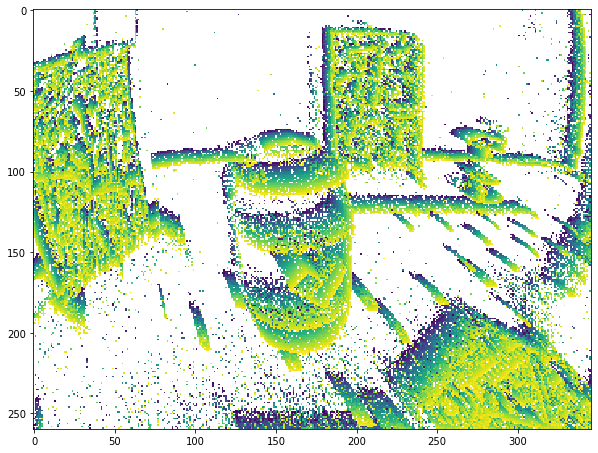

In [4047]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_raw, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")

In [4048]:
# patch_center = (100, 25)
# patch_size = 20
patch_center = (130, 173)
patch_size = 240
shape = (patch_size, patch_size)
events_p = flt.filter_patch(events_raw, patch_center, patch_size)

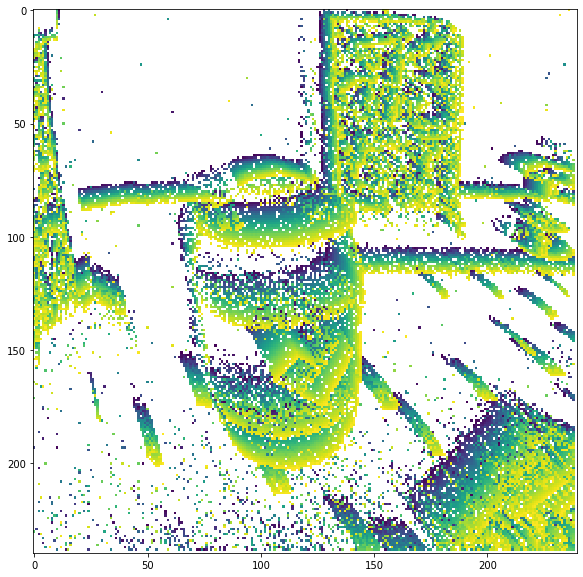

In [4049]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_p, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

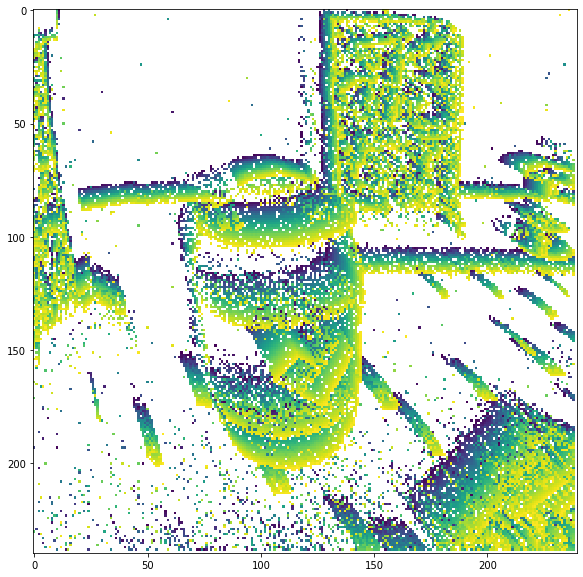

In [4050]:
events, result_shape = flt.filter_conv(events_p, shape, factor=1, thresh=1.0/2.0)
shape = result_shape
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, result_shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(ma

In [4051]:
# patch_center = (100, 25)
# patch_size = 20
# # patch_center = (90, 90)
# # patch_size = 180
# shape = (patch_size, patch_size)
# events_p = flt.filter_patch(events, patch_center, patch_size)

In [4052]:
# %matplotlib inline
# plt.figure(figsize=(10, 10))
# img = vis.events2time_surf(events_p, shape, filter_polarity=True, polarity=1)
# img_m = np.ma.masked_where(img == 0, img)
# m = plt.imshow(img_m, interpolation="none")
# #plt.colorbar(mappable=m)

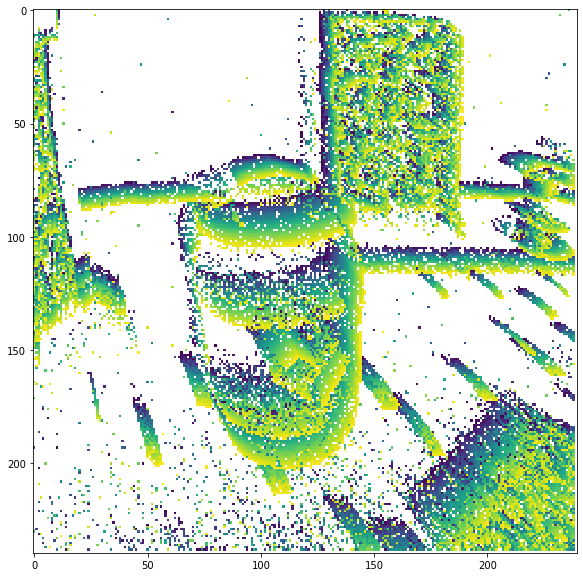

In [4053]:
events_ref = flt.filter_refract(events, 0.1)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_ref, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [4054]:
events = events_ref

In [4055]:
# shape = result_shape
# calib = np.loadtxt(path + dataset + "calib.txt")
focal_length = 226.38018519795807

In [4056]:
poses = mvsec_dset.load_poses(path + dataset + "indoor_flying1_gt.hdf5")

C:\Users/schiavaz/lava-nc/depth\events_utils\mvsec.py:65: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data_gt = h5py.File(f)


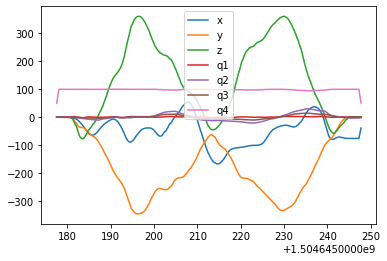

In [4057]:
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
plt.plot(poses[:,0], poses[:,4], label="q1")
plt.plot(poses[:,0], poses[:,5], label="q2")
plt.plot(poses[:,0], poses[:,6], label="q3")
plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [4058]:
def measure_td(events, shape, dist=1, start_delay=0.01):
    last_time = np.full(shape, -1.0)
    td_predictions = {}
    predictions = {}
    event_sign = np.full(shape, -1)

    U = np.zeros(shape)
    V = np.zeros(shape)

    start_time = events[0, 0]

    for e in tqdm(events):
        x = int(e[1])
        y = int(e[2])
        
#         if e[3] != 1:
#             continue

        last_sign = event_sign[y, x]
        last_time[y, x] = e[0]
        event_sign[y, x] = e[3]

        if e[0] < start_time + start_delay:
            continue

        u_td = (e[0] - last_time[y - dist, x]
                if y - dist >= 0 and last_time[y - dist, x] != -1.0 and event_sign[y - dist, x] == e[3]
                else -1.0)
        d_td = (e[0] - last_time[y + dist, x]
                if y + dist < shape[0] and last_time[y + dist, x] != -1.0 and event_sign[y + dist, x] == e[3]
                else -1.0)
        r_td = (e[0] - last_time[y, x + dist]
                if x + dist < shape[1] and last_time[y, x + dist] != -1.0 and event_sign[y, x + dist] == e[3]
                else -1.0)
        l_td = (e[0] - last_time[y, x - dist]
                if x - dist >= 0 and last_time[y, x - dist] != -1.0 and event_sign[y, x - dist] == e[3]
                else -1.0)

        if u_td <= 0.0:
            if d_td <= 0.0:
                v_td = 0.0
#                 continue
            else:
                v_td = d_td
        else:
            if d_td > 0:
                v_td = d_td if d_td <= u_td else -u_td
#                 v_td = 0.0
#                 continue
            else:
                v_td = -u_td

        if r_td <= 0.0:
            if l_td <= 0.0:
                h_td = 0.0
#                 continue
            else:
                h_td = l_td
        else:
            if l_td > 0:
                h_td = l_td if l_td <= r_td else -r_td
#                 h_td = 0.0
#                 continue
            else:
                h_td = -r_td
        
        if np.abs(v_td) < 0.005:
            v_td = 0.0
        if np.abs(h_td) < 0.005:
            h_td = 0.0

#         print(v_td)
#         print(h_td)
#         print("-----")
#         h_td = 0.0
            
        u =  dist /h_td if h_td != 0.0 else 0.0
        v =  dist / v_td if v_td != 0.0 else 0.0

                
        U[y, x] = u# if h_td != 0.0 else 0.0
        V[y, x] = v #if v_td != 0.0 else 0.0
#         U[y, x] = np.abs(h_td)
#         V[y, x] = np.abs(v_td)
        
    return U, V

In [4059]:
# U, V = measure_td(events, shape, dist=2)
U, V = td2d.measure_td(events, shape, dist=2, px_range_pred=9)

100%|█████████████████████████████████████████████████████████████████████████| 40941/40941 [00:01<00:00, 25391.70it/s]


In [4060]:
m = np.sqrt(U**2 + V**2)

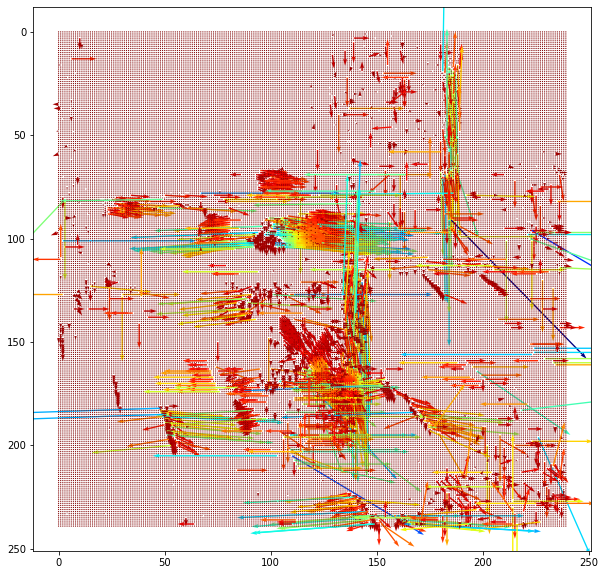

In [4061]:
%matplotlib inline
plt.figure(figsize=(10, 10))
a = 1
plt.quiver(U[::a, ::a], V[::a, ::a], m[::a, ::a], cmap="jet_r")
plt.gca().invert_yaxis()

0.018038034439086914
-90.38070990775017
74.2454242960348
---
378.1222629316158
311.36788988439554
367.4599722411299


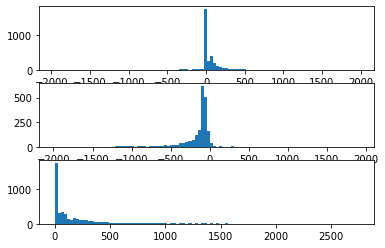

In [4062]:
u_m = np.ma.masked_where(np.isclose(U, 0.0), U)
v_m = np.ma.masked_where(np.isclose(V, 0.0), V)
m_m = np.ma.masked_where(np.isclose(m, 0.0), m)
fig, axs = plt.subplots(3)
axs[0].hist(u_m.compressed(), 100);
axs[1].hist(v_m.compressed(), 100);
axs[2].hist(m_m.compressed(), 100);
# plt.hist(u_m.compressed(), 100);
print(np.median(u_m.compressed()))
print(np.median(v_m.compressed()))
print(np.median(m_m.compressed()))
print("---")
print(np.std(u_m.compressed()))
print(np.std(v_m.compressed()))
print(np.std(m_m.compressed()))

In [3254]:
time_d = td2d.TimeDifference2d(shape, events, poses, focal_length)
final_td, td_predictions, U, V, diff_list = time_d.compute_time_difference(dist = 2, px_range_pred=11, delay=0.3, avg_n=10, std_mul=0.005, debug=True, start_delay=0.05)
m = np.sqrt(U**2 + V**2)

(2, 5694)
[0.00801858 0.005506   0.0295827 ]


100%|██████████████████████████████████████████████████████████████████████████████| 992/992 [00:00<00:00, 4488.00it/s]

total: 992
diff: 408
negative: 0
q: 0
ang: 0
ind: 1131
img: 8328
filtered: 0


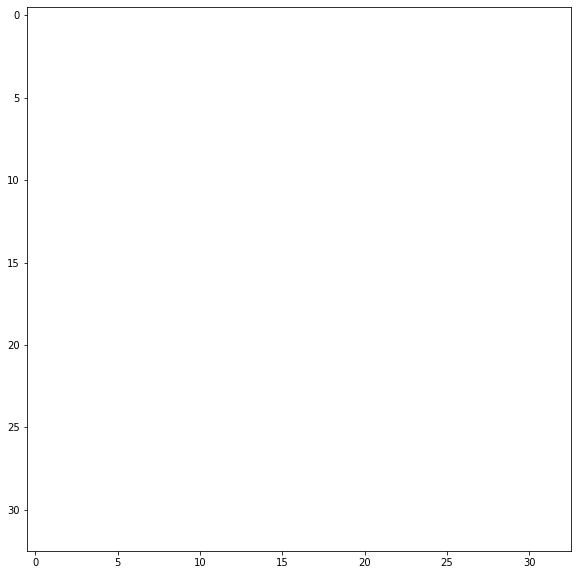

In [3255]:
plt.figure(figsize=(10, 10))
final_td_m = np.ma.masked_where(final_td ==0, final_td)
plt.imshow(final_td_m, interpolation="none", cmap="jet_r", vmax=0.05)

c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


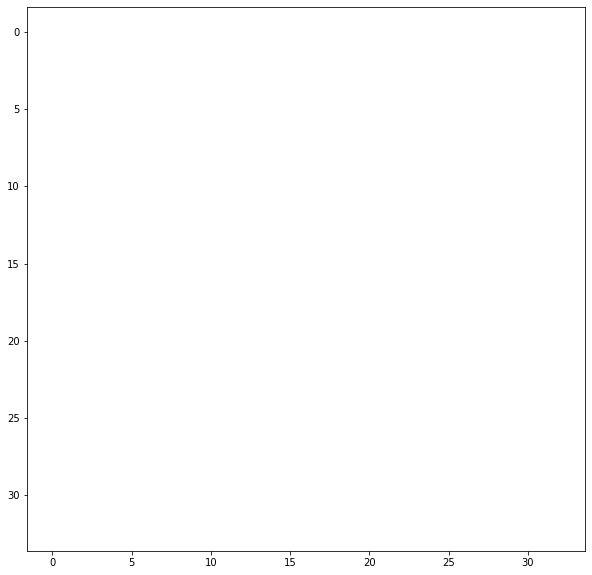

In [3256]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

In [ ]:
m_ma = np.ma.masked_where(np.isclose(m, 0.0), m)
plt.imshow(m_ma, interpolation="none")

C:\Users/schiavaz/lava-nc/depth\events_utils\mvsec.py:65: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data_gt = h5py.File(f)


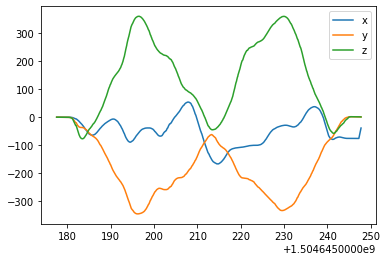

In [4063]:
poses = mvsec_dset.load_poses(path + dataset + "indoor_flying1_gt.hdf5")
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

# tmp = np.copy(poses[:,2])
# poses[:,2] = poses[:,3]
# poses[:,3] = tmp

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [4064]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

vel = (ang2 - ang1) / (pose2[0] - pose1[0])

print(vel)

[ 0.00333125 -0.00021743 -0.00276678]


In [4065]:
def get_angular_flow(w, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - int(shape[1] / 2)
            yi = y - int(shape[0] / 2)
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [(xi * yi) / f, -(f + xi ** 2 / f), yi],
                [f + yi ** 2 / f, -xi * yi / f, -xi]
            ])
            r = m @ w
            U_flow[y, x] = r[0]
            V_flow[y, x] = r[1]
            
    return U_flow, V_flow

In [4066]:
ang_U, ang_V = get_angular_flow(vel, focal_length, shape)

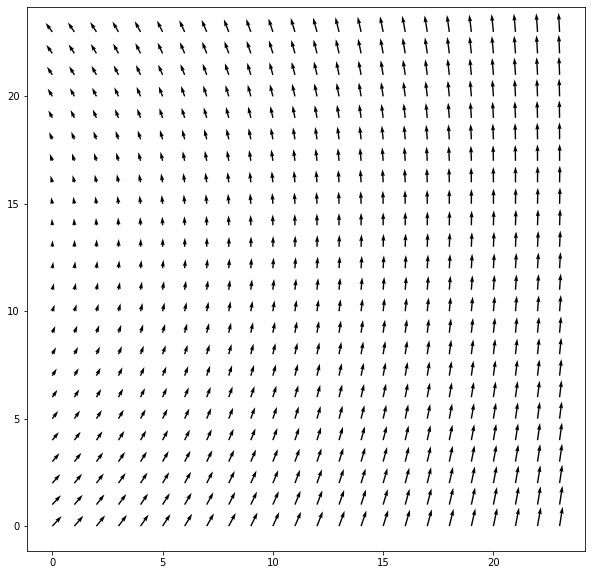

In [4067]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [4068]:
# idx = np.searchsorted(poses[:, 0], t_start + 1.0)
# pose1 = poses[idx]
# pose2 = poses[idx + 10]

# t1 = pose1[1:4]
# t2 = pose2[1:4]

# print(t1)
# print(t2)

# t_vel = (t2 - t1) / (pose2[0] - pose1[0])

# print(t_vel)
# print(pose2[0] - pose1[0])
# # t_vel = np.array([0, 0, 0.1])

odom = mvsec_dset.load_odom(path + dataset + "indoor_flying1_odom.npz")
idx = np.searchsorted(odom[:, 0], t_start + odom[0, 0])
print(odom[idx, 0] - odom[0, 0])
t_vel = odom[idx, 1:4]
t_vel[1]*=-1
print(idx)

16.054994583129883
321


In [4069]:
def get_translational_flow(t, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - int(shape[1] / 2)
            yi = y - int(shape[0] / 2)
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [-f, 0, xi],
                [0, -f, yi]
            ])
            r = m @ t
            U_flow[y, x] = r[0]
            V_flow[y, x] = r[1]
            
    return U_flow, V_flow

In [4070]:
t_U, t_V = get_translational_flow(t_vel, focal_length, shape)

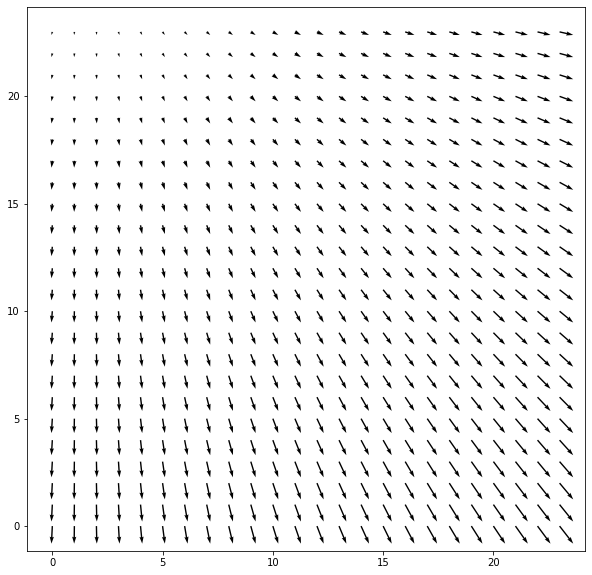

In [4071]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(t_U[::10, ::10], t_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [4072]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

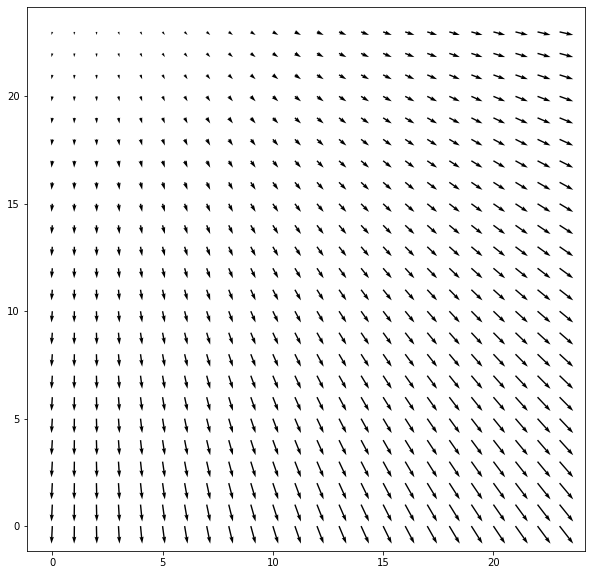

In [4073]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [4074]:
test_u = np.zeros(shape)
test_v = np.zeros(shape)
test = np.zeros(shape)
for x in range(U.shape[1]):
    for y in range(U.shape[0]):
        
        m = np.sqrt(np.square(U[y, x]) + np.square(V[y, x])) ** 2
        l = (ang_U[y, x]* U[y, x] + ang_V[y, x] * V[y, x]) / m

        if m == 0.0:
            continue
        
        ang_p_u = U[y, x] * l
        ang_p_v = V[y, x] * l
        
        U_t = U[y, x]# - ang_p_u
        V_t = V[y, x]# - ang_p_v
        
        test_u[y, x] = U_t
        test_v[y, x] = V_t
        
        n = np.sqrt(t_U[y, x]**2 + t_V[y, x]**2) ** 2
        p = (U_t*t_U[y, x] + V_t*t_V[y, x]) / n
        
        u = t_U[y, x] * p
        v = t_V[y, x] * p
        
        test_u[y, x] = u
        test_v[y, x] = v
        
        a = t_U[y, x] * u if u != 0.0 else 0.0
        b = t_V[y, x] * v if v != 0.0 else 0.0
        
        d = 1 / (a + b)
        
        d = np.sqrt(t_U[y, x]**2 + t_V[y, x]**2) / np.sqrt(u**2 + v**2)
        
        d = 1 / (t_U[y, x] / n * U_t + t_V[y, x] / n * V_t)
        
        if d<=0.0:
            continue

        test[y, x] = d

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_27316/3875608381.py:8: RuntimeWarning: invalid value encountered in double_scalars
  l = (ang_U[y, x]* U[y, x] + ang_V[y, x] * V[y, x]) / m


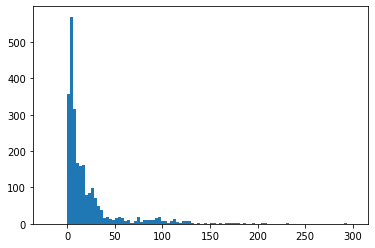

In [4075]:
test_m = np.ma.masked_where(test == 0.0, test)
plt.hist(test_m.compressed(), 100, range=(-20, 300));

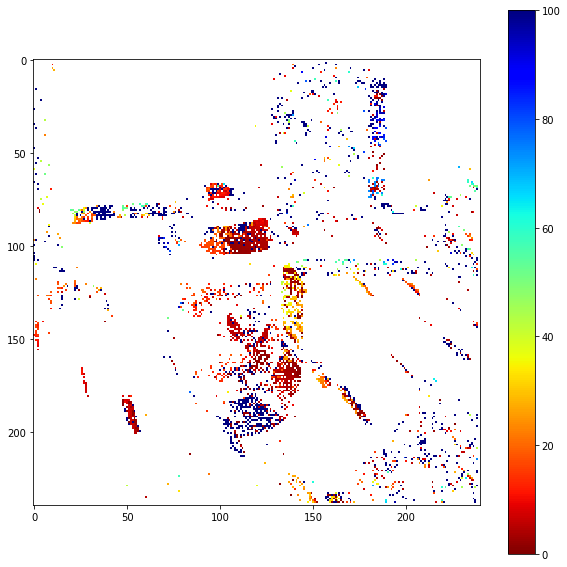

In [4076]:
plt.figure(figsize=(10, 10))
# img_gray = plt.imread(path + dataset + "images/frame_00000057.png")
# plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r", vmin=0, vmax=100)
plt.colorbar(m)

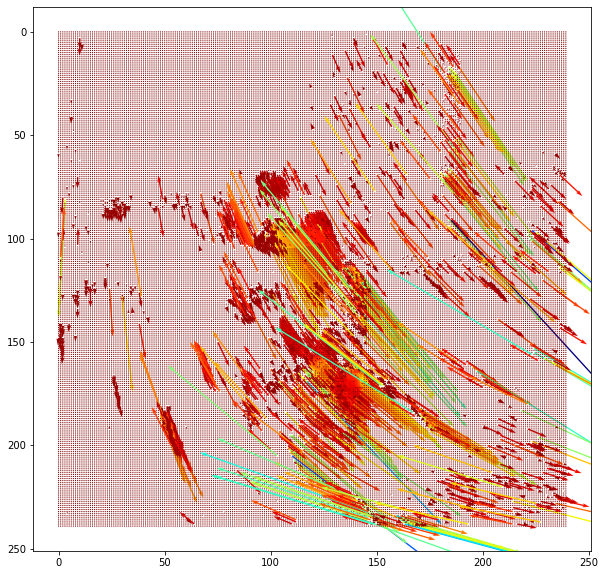

In [4077]:
%matplotlib inline
plt.figure(figsize=(10, 10))
m = np.sqrt(np.square(test_v) + np.square(test_u))
a = 1
plt.quiver(test_u[::a, ::a], test_v[::a, ::a], m[::a, ::a], cmap="jet_r")
plt.gca().invert_yaxis()

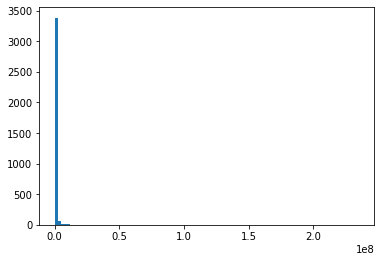

In [4078]:
test_m = np.ma.masked_where(test == 0.0, test)
plt.hist(test_m.compressed(), 100);

In [4079]:
depth_med = flt.median_filter(test_m, 5)
depth_med_m = np.ma.masked_where(depth_med == 0, depth_med)
# depth_r = flt.radius_filter(depth_med_m, 2, 4)

c:\users\schiavaz\lava-nc\venv\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\schiavaz\lava-nc\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


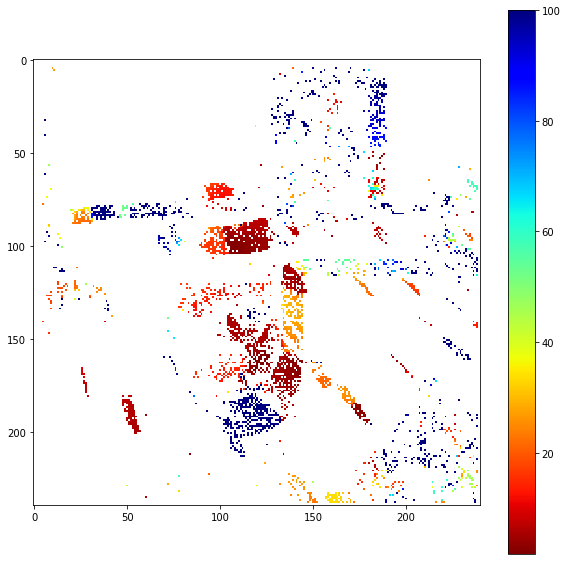

In [4080]:
plt.figure(figsize=(10, 10))
m = plt.imshow(depth_med_m, interpolation="none", cmap="jet_r", vmax=100)
plt.colorbar(m)

In [3899]:
%matplotlib qt
vis.visualize3d(depth_med_m, range=(0, 100))

In [3094]:
d = test_m

In [ ]:
gt_d = 0.584

In [ ]:
mean_error = np.mean(np.abs(d.compressed() - gt_d))
print(mean_error)

In [ ]:
median_error = np.median(np.abs(d.compressed() - gt_d))
print(median_error)